# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

----
## 步骤 1: 设计并测试一个模型架构
设计并实现一个能够识别数字序列的深度学习模型。你可以通过连接[notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html)或者是[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：
- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在softmax分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

你可以使用 Keras 来构建你的模型，[这里](https://keras.io/)了解更多。

这里有一个[发表的关于这个问题的基准模型的论文](https://github.com/nd009/machine-learning/blob/zh-cn/projects/digit_recognition/42241.pdf) [（视频）](http://cn-static.udacity.com/mlnd/videos/ICLR14_%20Goodfellow.mp4)的例子。我们并不要求你构建的模型架构跟论文上一摸一样或者达到它那样的模型表现。这里紧紧是展示一个解决这个问题的例子。我们鼓励你采用不同的架构，来看看哪种表现对你来说最好。你也可以看论坛上关于论文中架构的[讨论](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363)。

### 实现
使用下面的代码单元（必要的话可以使用多个代码单元）来实现你项目的第一步。一旦你完成了你的实现并且获得了满意的结果，请确认全面回答下面相关的问题。

In [1]:
### 在这里实现你的代码  
### 必要的话你可以随意添加更多的代码单元 
from __future__ import print_function
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import random
import os

import mnist_seq
mnist_seq = reload(mnist_seq)

%matplotlib inline

num_seqlen = 5
num_labels = mnist_seq.DIGITS

# Generate training data
random.seed(1)
train_data, train_labs = mnist_seq.gen_data(10000, seqs=num_seqlen)
test_data, test_labs = mnist_seq.gen_data(1000, test=True, seqs=num_seqlen)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


   0   1   2   3   4   5   6   7   8   9  B
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] (5, 11)


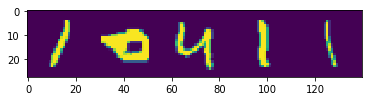

In [2]:
# test display
plt.figure()
rndsel = random.randint(0, len(train_data)-1)
plt.imshow(train_data[rndsel][:, :, -1]) 
print('   0   1   2   3   4   5   6   7   8   9  B')
print(train_labs[rndsel], train_labs[rndsel].shape)

In [3]:
import tensorflow as tf

def argmaxlab(lab):
    return np.argmax(lab.reshape(-1, num_seqlen, num_labels), 2)

def accuracy(predictions, labels):
    return (100.0 * np.sum(argmaxlab(predictions) == argmaxlab(labels))
          / (predictions.shape[0] * num_seqlen))

In [16]:
import helper
helper = reload(helper)

# Main Model
def my_model(x_input, drop=None):
    depth1, depth2, depth3, depth4 = 32, 64, 64, 256
    with tf.variable_scope("conv1"):
        relu = helper.conv_relu(x_input, kernel_shape=[3, 3, 1, depth1],  pool=True)
        
    with tf.variable_scope("conv2"):
        relu = helper.conv_relu(relu, kernel_shape=[3, 3, depth1, depth2],  pool=True)
        
    with tf.variable_scope("conv3"):
        relu = helper.conv_relu(relu, kernel_shape=[3, 3, depth2, depth3], pool=True)
        
    with tf.variable_scope("fully_connected"):
        shape = relu.get_shape().as_list()
        csize = shape[1] * shape[2] * shape[3]
        reshape = tf.reshape(relu, [-1, csize])    
        relu = helper.relu(reshape, [csize, depth4], drop=drop)
        
    with tf.variable_scope("out"):
        weights, biases = helper.var([depth4, num_labels * num_seqlen])
        return tf.matmul(relu, weights) + biases

clf = helper.Learner(my_model, accuracy, 
                     steps=601, batch_size=128,
                     loss=tf.nn.sigmoid_cross_entropy_with_logits,
                     optimizer=tf.train.AdamOptimizer,
                     save='first.model')

clf.fit(train_data, train_labs, test_data, test_labs)


Tensor("data:0", dtype=float32)
Tensor("predict/conv1/MaxPool:0", shape=(?, 14, 70, 32), dtype=float32)
Tensor("predict/conv2/MaxPool:0", shape=(?, 7, 35, 64), dtype=float32)
Tensor("predict/conv3/MaxPool:0", shape=(?, 4, 18, 64), dtype=float32)
Tensor("predict/fully_connected/dropout/mul:0", shape=(?, 256), dtype=float32)
Tensor("predict/conv1_1/MaxPool:0", shape=(1000, 14, 70, 32), dtype=float32)
Tensor("predict/conv2_1/MaxPool:0", shape=(1000, 7, 35, 64), dtype=float32)
Tensor("predict/conv3_1/MaxPool:0", shape=(1000, 4, 18, 64), dtype=float32)
Tensor("predict/fully_connected_1/Relu:0", shape=(1000, 256), dtype=float32)
None


ValueError: None values not supported.

In [13]:
helper = reload(helper)
clf = helper.Learner(my_model, accuracy, 
                     save='first.model')
clf.load(step="1000")

sample_idx = np.random.randint(len(test_data))  # pick a random image index
sample_image = test_data[sample_idx, :]  # extract a 2D slice
plt.imshow(sample_image.reshape(28, 28*5))  # display it

#saver = tf.train.Saver()
predict_lab = clf.predict([[sample_image]])
        
plt.xlabel(  predict_lab[0] )
print(predict_lab)
print((100.0 * np.sum(predict_lab == argmaxlab(test_labs[sample_idx]))
          / (1 * num_seqlen)))
t =( predict_lab == argmaxlab(test_labs[sample_idx]))
print(t, np.sum(t))

KeyError: "The name 'drop:0' refers to a Tensor which does not exist. The operation, 'drop', does not exist in the graph."

In [182]:
#训练太慢，明天来改快，顺便重启系统测试下gpu
#cd C:\Program Files\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tensorflow
#python -m tensorflow.models.image.mnist.convolutional
        

Initialized
Minibatch loss at step 0: 1.017308
Minibatch accuracy: 10.3%
Test accuracy: 12.3%
Minibatch loss at step 20: 0.269068
Minibatch accuracy: 32.5%
Test accuracy: 35.4%
Minibatch loss at step 40: 0.233555
Minibatch accuracy: 39.8%
Test accuracy: 45.9%
Minibatch loss at step 60: 0.207109
Minibatch accuracy: 46.2%
Test accuracy: 59.1%
Minibatch loss at step 80: 0.181550
Minibatch accuracy: 56.9%
Test accuracy: 70.1%
Minibatch loss at step 100: 0.147620
Minibatch accuracy: 66.6%
Test accuracy: 79.6%
Test accuracy: 79.6%


[[[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 ..., 
 [[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]]
[[0 0 0 0 0]]
0.0
[[False False False False False]] 0


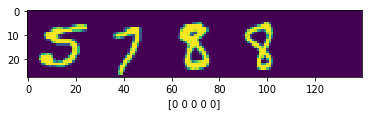

In [190]:
sample_idx = np.random.randint(len(test_data))  # pick a random image index
sample_image = test_data[sample_idx, :]  # extract a 2D slice
plt.imshow(sample_image.reshape(image_hight, image_width))  # display it

#saver = tf.train.Saver()
with tf.Session(graph=graph) as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))
    predict = tf.argmax(tf.reshape(logits, [-1, num_seqlen, num_labels]), 2)
    predict_lab = session.run(predict, feed_dict={tf_train_data: [sample_image]})
        
plt.xlabel(  predict_lab[0] )
print(predict_lab)
print((100.0 * np.sum(predict_lab == argmaxlab(test_labs[sample_idx]))
          / (1 * num_seqlen)))
t =( predict_lab == argmaxlab(test_labs[sample_idx]))
print(t, np.sum(t))


### 问题 1
_你为解决这个问题采取了什么方法？_

**回答：** 

### 问题 2
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 连接性等）_

**回答：**

### 问题 3
_你是如何训练你的模型的？你是如何合成数据集的？_请同时包括你创建的合成数据中的一些示例图像。

**回答：**

----
## 步骤 2: 在真实数据集上训练一个模型

一旦你确定好了一个好的模型架构，你就可以开始在真实的数据上训练你的模型了。特别地，[街景房屋门牌号(SVHN)](http://ufldl.stanford.edu/housenumbers/)数据集是一个大规模的，从谷歌街景数据中采集的门牌号数据。在这个更有挑战性的数据集（这里数字不是整齐排列的，并且会有各种倾斜、字体和颜色）上训练，可能意味着你必须做一些超参数探索以获得一个表现良好的模型。

### 实现
使用下面的代码单元（必要的话可以使用多个代码单元）来实现你项目。一旦你完成了你的实现并且获得了满意的结果，请确认全面回答下面相关的问题。

In [ ]:


### 在这里实现你的代码 
### 必要的话你可以随意添加更多的代码单元 

# def split_softmax_entropy(y_predict, y_real):
#     y_predict_spd = tf.reshape(y_predict, [-1, num_seqlen, num_labels])
#     y_real_spd    = tf.reshape(y_real,    [-1, num_seqlen, num_labels])
#     rtn = 0
#     for i in range(0, num_seqlen):
#         rtn += tf.reduce_mean(
#         tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labs, logits=logits))

### 问题 4
_描述如何为模型准备训练和测试数据。 模型在真实数据集上表现怎么样？_

**回答：**

### 问题 5
_你（在模型上）做了什么改变？如果做了一些改变，那么你得到一个“好的”结果了妈？有没有任何你探索的导致结果更糟？_

**回答：**

### 问题 6
_当你在真实数据集做测试的时候你的初始结果和最终结果是什么？你认为你的模型在正确分类数字这个任务上上做的足够好吗？_

**回答：**

----
## 步骤 3: 在新抓取的图片上测试模型

在你周围拍摄几张数字的图片（至少五张），然后用你的分类器来预测产生结果。或者（可选），你可以尝试使用OpenCV / SimpleCV / Pygame从网络摄像头捕获实时图像，并通过你的分类器分析这些图像。

### 实现
使用下面的代码单元（必要的话可以使用多个代码单元）来实现你项目的。一旦你完成了你的实现并且获得了满意的结果，请确认全面回答下面相关的问题。

In [ ]:


### 在这里实现你的代码  
### 必要的话你可以随意添加更多的代码单元 



### 问题 7
_选择在你周围拍摄的五张候选图片，并提供在报告中。它们中的某些图片是否有一些特殊的性质，可能会导致分类困难？_

**回答:**

### 问题 8
_与在现实数据集上的测试结果相比，你的模型能够在捕获的图片或实时相机流上表现同样良好吗？_

**回答:**

### 可选: 问题 9
_如果必要的话，请提供关于你是如何建立一个使得你的模型能够加载和分类新获取图像的接口的。_

**回答:** 如果你没有完成这个部分，那么这一块请保留空白

----
### 步骤 4: 探索一种提升模型的方式

一旦你基本的分类器训练好了，你就可以做很多事情。一个例子是：（在分类的同时）还能够定位图像上数字的位置。SVHN数据集提供边界框，你可以调试以训练一个定位器。训练一个关于坐标与边框的回归损失函数，然后测试它。

### 实现
使用下面的代码单元（必要的话可以使用多个代码单元）来实现你项目的。一旦你完成了你的实现并且获得了满意的结果，请确认全面回答下面相关的问题。

In [ ]:


### 在这里实现你的代码
### 必要的话你可以随意添加更多的代码单元 



### 问题 10
_你的模型在真实数据的测试集上定位数字表现的怎么样？包含位置信息之后你的分类结果有变化吗？_

**回答：**

### 问题 11
在你在**步骤3 **所捕获的图像上测试你的定位功能。模型是否准确计算出你找到的图像中的数字的边界框？如果你没有使用图形界面，您可能需要手动探索边界框。_提供一个在捕获的图像上创建边界框的示例_。

**回答：**

----
## 可选步骤 5：为模型封装一个应用或者是程序

为了让你的项目更进一步。如果你有兴趣，可以构建一个安卓应用程序，或者是一个更鲁棒的Python程序。这些程序能够和输入的图像交互，显示分类的数字甚至边界框。比如，你可以尝试通过将你的答案叠加在图像上像[Word Lens](https://en.wikipedia.org/wiki/Word_Lens)应用程序那样来构建一个增强现实应用程序。

如何在安卓上的相机应用程序中加载TensorFlow的模型的示例代码在[TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android)中，你可以再这个基础上做一些简单的修改。


如果你决定探索这条可选路径，请务必记录你的接口和实现，以及你找到的重要结果。你可以通过[点击这个链接](https://review.udacity.com/#!/rubrics/413/view)看到将被用来评价你的工作的相关条目。

### 可选 实现
使用下面的代码单元（必要的话可以使用多个代码单元）来实现你项目的。一旦你完成了你的实现并且获得了满意的结果，请确认全面回答下面相关的问题。

In [ ]:


### 在这里实现你的代码  
### 必要的话你可以随意添加更多的代码单元 



### 文档
请提供额外的文档，这些文档要足以详细说明安卓应用程序或Python程序如何实现可视化图像中数字的分类。你的描述应该清楚描述程序或应用程序的工作原理并提供一些演示。

_在这里写你的文档_

> **注意:** 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。